该脚本主要练习tensorflow.
该脚本学习书上第15章——Autoencoder的基础内容。包括：  
①使用线性欠完备自编码器实现PCA（hidden_layer的低位向量即压缩的特征向量)  
②通过两个graph分开train,一个train外层自编码器，一个train隐藏层自编码器,然后获取训练好的权重，直接用权重矩阵(而不是tensor),实现一个stacked autoencoder  
③实现一个sparse autoencoder,使用hidden layer的总体激活程度（每个样本所有神经元平均激活，再对所有样本进行平均）
④实现一个denoise autoencoder

### 第一部分：使用欠完备线性自编码器实现PCA  
当自编码器使用线性激活函数，且代价函数为MSE时，其实就是在实现PCA  

In [25]:
%matplotlib inline
from tensorflow.contrib.layers import fully_connected
import tensorflow as tf
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from functools import partial
from tensorflow.examples.tutorials import mnist
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
#例子：使用一个隐藏层的自编码器实现PCA，将3-D数据集投影至2-D
n_inputs=3
n_hidden=2
n_outputs=n_inputs
learning_rate = 0.01
inputs = tf.placeholder(dtype=tf.float32,shape=[None,n_inputs])
hidden = tf.layers.dense(inputs,n_hidden,activation=None)
outputs = tf.layers.dense(hidden, n_outputs, activation=None)
reconstruction_loss = tf.reduce_mean(tf.square(outputs-inputs))
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
init = tf.global_variables_initializer()

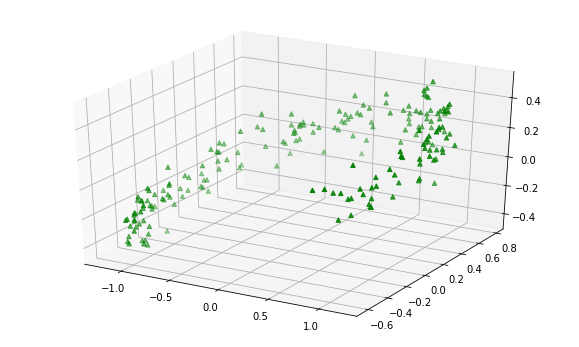

In [3]:
#准备数据集：
rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)
# ax = plt.figure().add_subplot(111, projection = '3d')  
def plot_dataset(data):
    fig = plt.figure(figsize=(10,6))
    ax = fig.gca(projection='3d')
    x, y, z = data[:,0], data[:,1], data[:,2]
    ax.scatter(x, y, z, c = 'g', marker = '^')
plot_dataset(data)

In [4]:
# Excuting Phase:
std_scl = StandardScaler()
X_train = std_scl.fit_transform(data[:100])
X_test = std_scl.transform(data[100:])

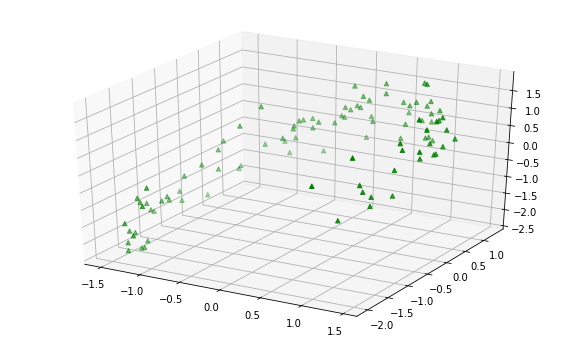

In [5]:
plot_dataset(X_train) 

In [6]:
n_iterations = 1000
codings = hidden #隐藏层的输出提供了codings？？？
with tf.Session() as sess:
    init.run()
    for iter in range(n_iterations):
        sess.run(training_op,feed_dict = {inputs:X_train}) #注意：没有标签（无监督）
        if iter%100 ==0 :
            loss = reconstruction_loss.eval(feed_dict={inputs:X_train})
            print('reconstruction_loss: {}'.format(loss))
    codings_val = codings.eval(feed_dict={inputs:X_test})

reconstruction_loss: 1.2343823909759521
reconstruction_loss: 0.18567366898059845
reconstruction_loss: 0.1689417064189911
reconstruction_loss: 0.1628021001815796
reconstruction_loss: 0.08313129842281342
reconstruction_loss: 0.04837697371840477
reconstruction_loss: 0.04585982486605644
reconstruction_loss: 0.04550499469041824
reconstruction_loss: 0.04546354338526726
reconstruction_loss: 0.04545922204852104


Text(0,0.5,'$z_2$')

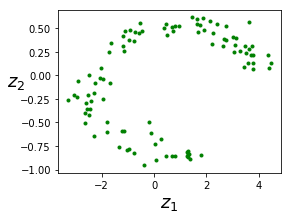

In [7]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:, 1], "g.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)

===================================================================================  
## 第二部分：作为早上的编程任务:  
实现一个三个hidden layer的stacked autoencoder，并且使用多个graph将autoencoder分开训练  
对重建结果以及特征进行可视化  

====================================================================================

In [8]:
mnist = mnist.input_data.read_data_sets('/home/fp/MNIST_data/')

Extracting /home/fp/MNIST_data/train-images-idx3-ubyte.gz
Extracting /home/fp/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /home/fp/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /home/fp/MNIST_data/t10k-labels-idx1-ubyte.gz


In [9]:
def train_autoencoder(X_train,hidden_size,learning_rate=0.01,
                      l2_reg = 0.0005,hidden_activation=tf.nn.elu,
                     output_activation=tf.nn.elu,batch_size=32,
                     epochs = 50):
    graph = tf.Graph() #每次调用函数创建一个新的Graph
    with graph.as_default():
        input_size = X_train.shape[-1]
        X = tf.placeholder(dtype='float',shape=[None,input_size])
        my_dense_layer = partial(tf.layers.dense,
                                 kernel_initializer = tf.contrib.layers.variance_scaling_initializer(),
                                 kernel_regularizer = tf.contrib.layers.l2_regularizer(l2_reg))
        hidden = my_dense_layer(X,hidden_size,activation=hidden_activation,name='hidden')
        outputs = my_dense_layer(hidden,input_size,activation=output_activation,name='output')
        reconstruction_loss = tf.reduce_mean(tf.square(X-outputs))
        reg_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss]+reg_loss)
        optimizer = tf.train.AdamOptimizer(learning_rate)
        train_op = optimizer.minimize(loss)
        init = tf.global_variables_initializer()
        
    with tf.Session(graph=graph) as sess:
        sess.run(init)
        for epoch in range(epochs):
            n_batches = len(X_train) // batch_size 
            for iter in range(n_batches):
                batch_ind = np.random.permutation(len(X_train))[:batch_size] #准备mini-batch
                X_batch = X_train[batch_ind]
                sess.run(train_op,feed_dict={X:X_batch})
                if iter %(1000)==0:
                    Loss = loss.eval(feed_dict = {X:X_batch})
                    print('Epoch: {0}  Iter: {1} Loss: {2}'.format(epoch,iter,Loss))
        #训练完之后获取所有参数值并保存
        params = dict([(var.name,var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={X:X_train}) #不是X_batch了
    return hidden_val, params['hidden/kernel:0'],params['hidden/bias:0'],params['output/kernel:0'],params['output/bias:0']

In [10]:
hidden, W1,b1,W4,b4 = train_autoencoder(mnist.train.images, 
                                        hidden_size=300,epochs=4,batch_size=150,output_activation=None)
_,W2,b2,W3,b3 = train_autoencoder(hidden,hidden_size=150,epochs=4,batch_size=150)

Epoch: 0  Iter: 0 Loss: 1.4668000936508179
Epoch: 1  Iter: 0 Loss: 0.031666357070207596
Epoch: 2  Iter: 0 Loss: 0.032614920288324356
Epoch: 3  Iter: 0 Loss: 0.03232831507921219
Epoch: 0  Iter: 0 Loss: 0.45466092228889465
Epoch: 1  Iter: 0 Loss: 0.01773025654256344
Epoch: 2  Iter: 0 Loss: 0.017531534656882286
Epoch: 3  Iter: 0 Loss: 0.017648430541157722


·问题：上面训练的AutoEncoder,W1与W4.T为啥不相等？(tying weights)

接下来使用非监督预训练模型获取的权重训练另一个神经网络

In [11]:
SAVE_DIR = '/home/fp/CHIYUAN/MyProject/models_saved/AutoEncoder/'
tf.reset_default_graph()
n_inputs = 28*28
X=tf.placeholder('float',shape=[None,n_inputs])
hidden1 = tf.nn.elu(tf.matmul(X,W1)+b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1,W2)+b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2,W3)+b3)
outputs = tf.matmul(hidden3,W4)+b4 #最后一层没有激活函数

In [12]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), interpolation="nearest")
    plt.axis("off")
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(n_test_digits*8, 16))
    for digit_index in range(n_test_digits):
        plt.subplot(2, n_test_digits, digit_index+1)
        plot_image(X_test[digit_index]) 
        plt.subplot(2, n_test_digits, digit_index+1+n_test_digits)
        plot_image(outputs_val[digit_index])

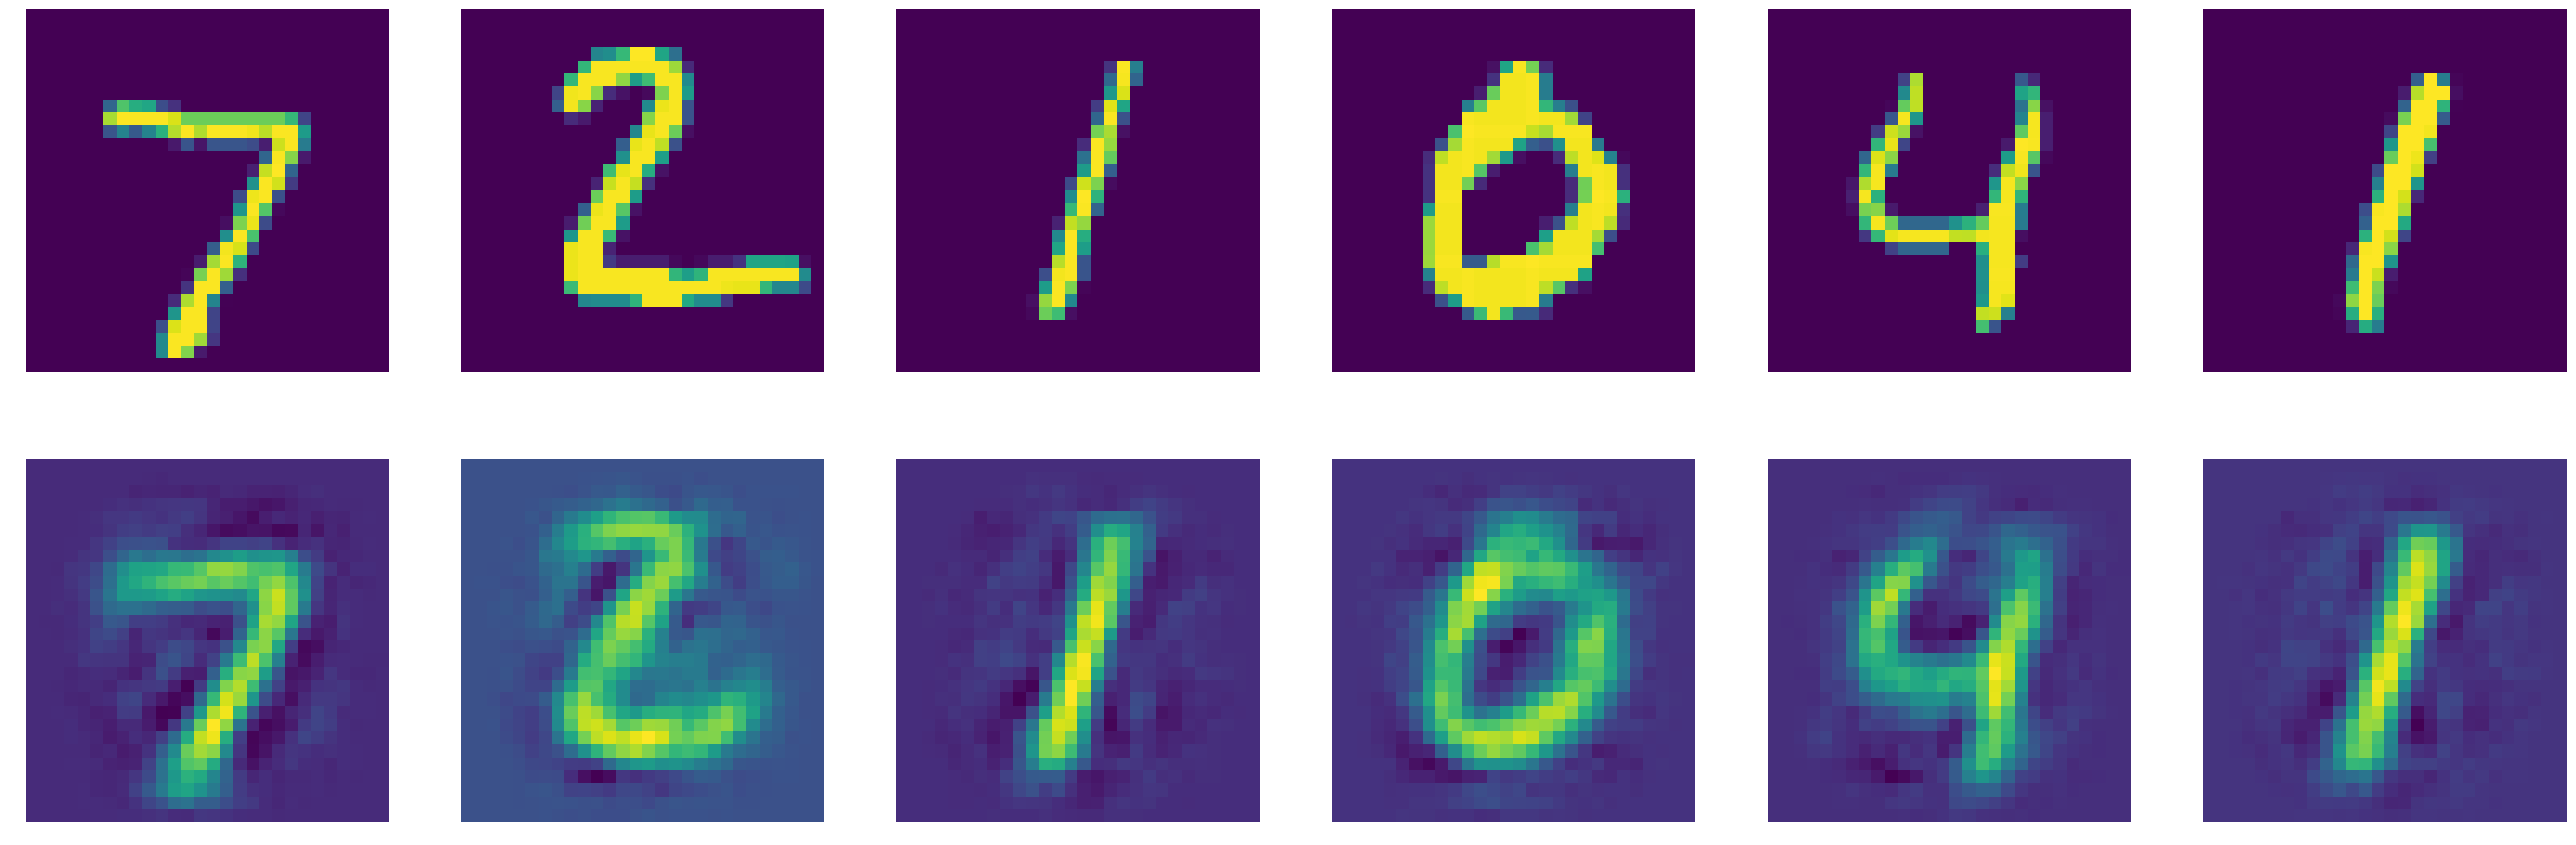

In [13]:
show_reconstructed_digits(X,outputs,n_test_digits=6)

特征可视化：（这一部分应当对多种特征可视化的思路进行整理）

这里首先使用书上的思路：如对于第一个隐藏层，共有300个神经元，每一个神经元对应784个连接.可视化出一幅图像，其像素对应这784个连接

In [14]:
print(W1.T.shape)

(300, 784)


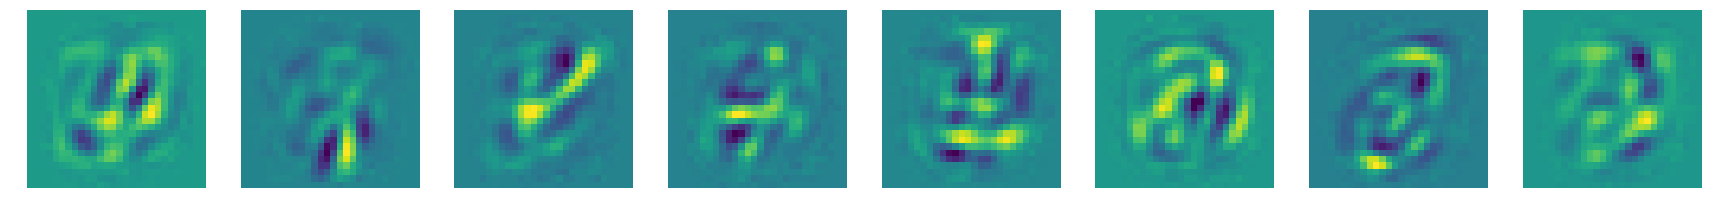

In [15]:
plt.figure(figsize=(30,24))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(W1.T[i].reshape(28,28))
    plt.axis('off')

## 第三部分：Sparse AE

主要思想:sparsity是另一种对AE的约束，push the autoencoder to reduce the number of active neurons in the coding layer,比如使coding layer中只有5%的激活神经元。这样迫使自编码器只用很小数量的一组activation的线性组合来表达输入。  

第一步：选择一个测度，来评价稀疏程度：计算在一个training batch上，coding layer的每个神经元的平均activation（batch不能太小，否则平均结果不精确）　 

第二步：选择一个sparsity loss,当神经元激活太多个时，給予惩罚.可以设置一个target sparsity,如0.1，当神经元激活程度为0.3时:  
最简单的，计算squared error（0.3-0.1）$^2$作为目标函数  
不过实际情况一种更好的选择是使用Ｋ-Ｌ散度（比MSE拥有更强的梯度）  
计算公式：$D_{KL}(p||q) = p*logp/q + (1-p)*log((1-p)/(1-q))$  
其中p为target probability,q为每个batch上一个神经元实际activate概率

第三步：将sparsity loss和reconstruction loss加在一起作为最后的loss。可以对sparsity loss乘以一个sparsity_weight来约束，不至于让网络太过稀疏而忽略重建部分

[0, 1, 0, 0.95]

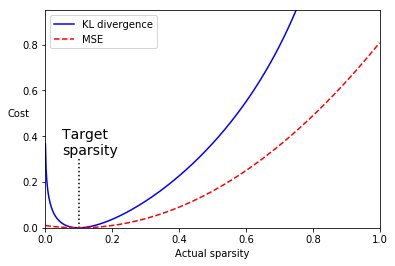

In [16]:
#绘制K-L散度示意图（直接copy的）
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mse, "r--", label="MSE")
plt.legend(loc="upper left")
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])

In [17]:
from functools import partial
def kl_divergince(p,q):
    return p*tf.log(p/q) + (1-p)*tf.log((1-p)/(1-q)) #不要太依赖np

In [30]:
sparsity_target = 0.1
sparsity_weight = 0.2
learning_rate = 0.01
img_size = 784
hidden_size = 1000 #sparse coding
X = tf.placeholder(tf.float32,shape=[None,img_size])
hidden = tf.layers.dense(X,hidden_size,activation=tf.nn.sigmoid)
outputs = tf.layers.dense(hidden,img_size)

hidden_mean = tf.reduce_mean(hidden,axis=0) #在每一行上求平均，结果：None个样本，每行代表每个样本上平均一个神经元的activation
sparsity_loss = tf.reduce_sum(kl_divergince(sparsity_target,hidden_mean))#注意这里用的不是平均而是sum
reconstruction_loss = tf.reduce_mean(tf.square(X-outputs))
loss = reconstruction_loss + sparsity_weight * sparsity_loss
optimizer = tf.train.AdamOptimizer(learning_rate)
train_op = optimizer.minimize(loss)
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [42]:
epochs = 40
batch_size = 1000
n_batches = mnist.train.num_examples//batch_size
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(epochs):
        for iter in range(n_batches):
            train_batch,_ = mnist.train.next_batch(batch_size)
            sess.run(train_op,feed_dict={X:train_batch})
            if iter%100==0:
                Loss = loss.eval(feed_dict={X:train_batch})
                print('Epochs: {0} Iter: {1} Loss: {2}'.format(epoch,iter,Loss))
    outputs_eval = outputs.eval(feed_dict={X:mnist.test.images})

Epochs: 0 Iter: 0 Loss: 24.31966209411621
Epochs: 1 Iter: 0 Loss: 0.15768015384674072
Epochs: 2 Iter: 0 Loss: 0.07330814749002457
Epochs: 3 Iter: 0 Loss: 0.07588616758584976
Epochs: 4 Iter: 0 Loss: 0.05568286404013634
Epochs: 5 Iter: 0 Loss: 0.12795189023017883
Epochs: 6 Iter: 0 Loss: 0.0510534904897213
Epochs: 7 Iter: 0 Loss: 0.05228637158870697
Epochs: 8 Iter: 0 Loss: 0.0456153079867363
Epochs: 9 Iter: 0 Loss: 0.055143214762210846
Epochs: 10 Iter: 0 Loss: 0.07600084692239761
Epochs: 11 Iter: 0 Loss: 0.03497530519962311
Epochs: 12 Iter: 0 Loss: 0.02888881415128708
Epochs: 13 Iter: 0 Loss: 0.03926888853311539
Epochs: 14 Iter: 0 Loss: 0.05085300654172897
Epochs: 15 Iter: 0 Loss: 0.03849094361066818
Epochs: 16 Iter: 0 Loss: 0.055197108536958694
Epochs: 17 Iter: 0 Loss: 0.054491207003593445
Epochs: 18 Iter: 0 Loss: 0.031470052897930145
Epochs: 19 Iter: 0 Loss: 0.030756201595067978
Epochs: 20 Iter: 0 Loss: 0.026625994592905045
Epochs: 21 Iter: 0 Loss: 0.036631807684898376
Epochs: 22 Iter: 

In [23]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), interpolation="nearest")
    plt.axis("off")
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(n_test_digits*8, 16))
    for digit_index in range(n_test_digits):
        plt.subplot(2, n_test_digits, digit_index+1)
        plot_image(X_test[digit_index]) 
        plt.subplot(2, n_test_digits, digit_index+1+n_test_digits)
        plot_image(outputs_val[digit_index])

In [43]:
outputs_eval.shape

(10000, 784)

## 第四部分：去噪自编码器  
主要思想：自编码器输入为带噪声图像，将重建图像与原始干净图像的mse作为loss函数来优化

In [100]:
from tensorflow.examples.tutorials import mnist

In [101]:
mnist=mnist.input_data.read_data_sets('mnist/')
X = mnist.train.images
X_test=mnist.test.images
print(X.shape)

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz
(55000, 784)


In [122]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), interpolation="nearest",cmap='gray')
    plt.axis("off")

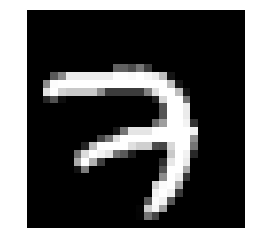

In [123]:
plot_image(X[0])

In [103]:
def get_random_batch(data,batch_size):
    m = data.shape[0]
    return data[np.random.choice(m,batch_size,replace=True)]

给原图像加上高斯噪声  
问题：使用tensorflow在训练过网络之后，要用网络对任意一个输入进行predict时需要使用sess.eval,这样就必须保证在一个Session之内进行.可以使用一个helper function,在其中定义一个新的会话进行eval

In [117]:
epochs=5
batch_size=32
learning_rate=1e-4
n_batchs=len(X)//batch_size
clean=tf.placeholder(tf.float32,shape=[None,28*28])
x_noise = clean + 0.1*tf.random_normal(tf.shape(clean))
#搭建网络
hidden=tf.layers.dense(inputs=x_noise,units=100,activation=tf.nn.elu)
outputs=tf.layers.dense(inputs=hidden,units=28*28,activation=None)

loss=tf.reduce_mean(tf.losses.mean_squared_error(outputs,clean))
optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss)
init=tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for e in range(epochs):
        for i in range(n_batchs):
            train_batch = get_random_batch(X,batch_size=batch_size)
            sess.run(train_op,feed_dict={clean:train_batch})
            if i %n_batchs==0:
                ls_eval=loss.eval({clean:train_batch})
                print('epoch:{0}  loss{1:.3f}'.format(e,ls_eval))
    noise_eval=x_noise.eval(feed_dict={clean:X_test})
    rec_eval=outputs.eval(feed_dict={clean:X_test})

epoch:0  loss0.147
epoch:1  loss0.028
epoch:2  loss0.013
epoch:3  loss0.010
epoch:4  loss0.009


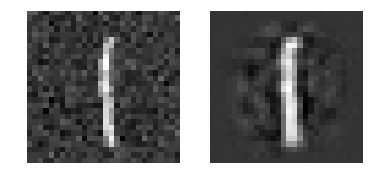

In [124]:
plt.subplot(121)
plot_image(noise_eval[203])
plt.subplot(122)
plot_image(rec_eval[203])

ValueError: Cannot evaluate tensor using `eval()`: No default session is registered. Use `with sess.as_default()` or pass an explicit session to `eval(session=sess)`

In [91]:
def eval_denoised_image(image):
    image=np.array([image])
    with tf.Session() as sess:
        plt.subplot(131)
        plot_image(image)
        plt.subplot(132)
        plot_image(x_noise.eval(feed_dict={clean:image}))
        plt.subplot(133)
        plot_image(outputs.eval(feed_dict={clean:image}))    

FailedPreconditionError: Attempting to use uninitialized value dense_22/kernel
	 [[Node: dense_22/kernel/read = Identity[T=DT_FLOAT, _class=["loc:@dense_22/kernel"], _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_22/kernel)]]
	 [[Node: dense_24/BiasAdd/_7 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_31_dense_24/BiasAdd", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'dense_22/kernel/read', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-84-4ce212d77bd4>", line 8, in <module>
    hidden=tf.layers.dense(inputs=x_noise,units=100,activation=tf.nn.elu)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/layers/core.py", line 250, in dense
    return layer.apply(inputs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/layers/base.py", line 671, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/layers/base.py", line 559, in __call__
    self.build(input_shapes[0])
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/layers/core.py", line 137, in build
    trainable=True)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/layers/base.py", line 458, in add_variable
    trainable=trainable and self.trainable)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/variable_scope.py", line 1203, in get_variable
    constraint=constraint)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/variable_scope.py", line 1092, in get_variable
    constraint=constraint)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/variable_scope.py", line 425, in get_variable
    constraint=constraint)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/variable_scope.py", line 394, in _true_getter
    use_resource=use_resource, constraint=constraint)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/variable_scope.py", line 805, in _get_single_variable
    constraint=constraint)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/variables.py", line 213, in __init__
    constraint=constraint)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/variables.py", line 356, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/array_ops.py", line 125, in identity
    return gen_array_ops.identity(input, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 2071, in identity
    "Identity", input=input, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value dense_22/kernel
	 [[Node: dense_22/kernel/read = Identity[T=DT_FLOAT, _class=["loc:@dense_22/kernel"], _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_22/kernel)]]
	 [[Node: dense_24/BiasAdd/_7 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_31_dense_24/BiasAdd", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


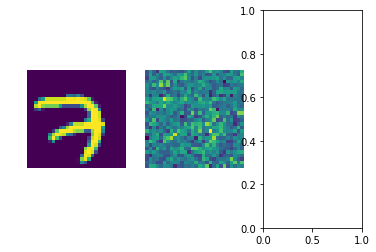

In [92]:
eval_denoised_image(X[0])